# Cloudy With a Chance of Football
## Global Machine Learning Model Part One: Data Preparation
<a id='header_cell'></a>

Author: Aidan O'Connor   
Date: 1 June 2021   

<img src='../../fixtures/images/tom_brady_10-finger.jpeg' alt="drawing" width="800"/> 
*Tom Brady showing how many hours it took to shift the ```stats``` data (photo courtesy of [E!](https://www.eonline.com/news/666675/tom-brady-dancing-like-your-lame-drunk-uncle-is-the-only-video-you-need-to-watch-right-now))*

### Table of Contents:
- [Import packages, read in data, set options](#import_and_options_cell)
- [Merging Datasets to Make a Dataframe](#merging_datasets_cell)
    - [1. ```stats``` Dataframe](#stats_dataframe)
    - [2. ```days_since_last_game``` Dataframe](#days_since_last_game_dataframe)
    - [3. ```hours_displaced``` Dataframe](#hours_displaced_dataframe)
    - [4. ```weather``` Dataframe](#weather_dataframe)
    - [5. ```elevation``` Dataframe](#elevation_dataframe)
    - [6. Concatenating the ```home``` and ```away``` Dataframes](#concat_home_away_dataframe)
    - [7. Adding ```player_age``` to Dataframe](#adding_age_dataframe)
    - [8. Shifting all stats columns 1 week](#shifting_stats)
    - [9. Adding the ```target``` dataframe](#target_dataframe)
    - [10. Writing the merged data for common use](#writing_data)

### Import packages, read in data, set options
<a id='import_and_options_cell'></a>
I'll start by importing all necessary packages to import, manipulate, visualize, and create machine learning models for data.   

Then, I'll set some preferences for some of these packages.   

Finally, I'll access our sqlite3 database and bring in a series of dataframes from the tables, then merge them. I chose not to do this with a single SQL statement, since I tried this with some difficulty

In [203]:
# Packages to import and manipulate data
import sqlite3
import pandas as pd
import numpy as np

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,7)
plt.style.use('fivethirtyeight')

In [3]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

In [4]:
cursorObj.execute("select * from SQLite_master")

tables = cursorObj.fetchall()

print("Here are the tables and indices from the main database:")
for table in tables:
        print(f"Type of database object: {table[0]}")
        print(f"Name of the database object: {table[1]}")
        print(f"Table Name: {table[2]}")
        print(f"Root page: {table[3]}")
        print(f"SQL statement: {table[4]}")

Here are the tables and indices from the main database:
Type of database object: table
Name of the database object: positions
Table Name: positions
Root page: 2
SQL statement: CREATE TABLE "positions" (
"PlayerID" INTEGER,
  "Position" TEXT
)
Type of database object: table
Name of the database object: player_dob
Table Name: player_dob
Root page: 125
SQL statement: CREATE TABLE "player_dob" (
"PlayerID" INTEGER,
  "dob" TEXT
)
Type of database object: table
Name of the database object: players
Table Name: players
Root page: 154
SQL statement: CREATE TABLE "players" (
"PlayerID" INTEGER,
  "FirstName" TEXT,
  "LastName" TEXT,
  "uniqueID" TEXT
)
Type of database object: table
Name of the database object: player_team
Table Name: player_team
Root page: 190
SQL statement: CREATE TABLE "player_team" (
"PlayerID" INTEGER,
  "week_id" TEXT,
  "Team" TEXT
)
Type of database object: table
Name of the database object: player_age
Table Name: player_age
Root page: 393
SQL statement: CREATE TABLE "p

In [199]:
birthday = pd.read_sql_query('SELECT * from player_dob', conn)

positions = pd.read_sql_query('SELECT * from positions',conn)

player_team = pd.read_sql_query('SELECT * from player_team',conn)

player_age = pd.read_sql_query('SELECT * from player_age',conn)

injury_status = pd.read_sql_query('SELECT * from injury_status',conn)

days_since_last_game = pd.read_sql_query('SELECT * from days_since_last_game',conn)

weather = pd.read_sql_query('SELECT * from weather',conn)

hours_displaced = pd.read_sql_query("""
                                    SELECT week_id,
                                    team_away_short,
                                    team_home_short,
                                    absolute_hours_displaced 
                                    from hours_displaced
                                    """,
                                    conn)
target = pd.read_sql_query('SELECT * from performance_target',
                            conn)

elevation = pd.read_sql_query("""
                              SELECT Team,
                              elevation
                              from elevation_and_conference
                              """,
                              conn)

stats = pd.read_sql_query("""
                          SELECT PlayerID,
                          SeasonType,
                          Season,
                          GameDate,
                          Week,
                          Team,
                          PositionCategory,
                          Played,
                          Started,
                          PassingAttempts,
                          PassingCompletions,
                          PassingYards,
                          PassingCompletionPercentage,
                          PassingYardsPerAttempt,
                          PassingYardsPerCompletion,
                          PassingTouchdowns,
                          PassingInterceptions,
                          PassingRating,
                          PassingLong,
                          PassingSacks,
                          PassingSackYards,
                          RushingAttempts,
                          RushingYards,
                          RushingYardsPerAttempt,
                          RushingTouchdowns,
                          RushingLong,
                          ReceivingTargets,
                          Receptions,
                          ReceivingYards,
                          ReceivingYardsPerReception,
                          ReceivingTouchdowns,
                          ReceivingLong,
                          Fumbles,
                          FumblesLost,
                          PuntReturns,
                          PuntReturnYards,
                          PuntReturnTouchdowns,
                          KickReturns,
                          KickReturnYards,
                          KickReturnTouchdowns,
                          SoloTackles,
                          AssistedTackles,
                          TacklesForLoss,
                          Sacks,
                          SackYards,
                          QuarterbackHits,
                          PassesDefended,
                          FumblesForced,
                          FumblesRecovered,
                          FumbleReturnTouchdowns,
                          Interceptions,
                          InterceptionReturnTouchdowns,
                          FieldGoalsAttempted,
                          FieldGoalsMade,
                          ExtraPointsMade,
                          TwoPointConversionPasses,
                          TwoPointConversionRuns,
                          TwoPointConversionReceptions,
                          ExtraPointsAttempted,
                          FieldGoalsMade0to19,
                          FieldGoalsMade20to29,
                          FieldGoalsMade30to39,
                          FieldGoalsMade40to49,
                          FieldGoalsMade50Plus,
                          week_id,
                          HomeOrAway,
                          Opponent
                          from stats_regular
                          """,
                          conn)

redzone = pd.read_sql_query("""
                            SELECT PlayerID,
                            OpponentRZ,
                            PassingYardsRZ,
                            PassingTouchdownsRZ,
                            PassingInterceptionsRZ,
                            RushingYardsRZ,
                            RushingTouchdownsRZ,
                            ReceptionsRZ,
                            ReceivingYardsRZ,
                            ReceivingTouchdownsRZ,
                            SacksRZ,
                            InterceptionsRZ,
                            FumblesForcedRZ,
                            FumlbesRecoveredRZ,
                            FantasyPointsRZ,
                            Season,
                            week_id
                            from redzone_stats
                            """,
                            conn)

defense = pd.read_sql_query("""
                            SELECT PointsAllowed,
                            Team,
                            TouchdownsScored,
                            Sacks,
                            SackYards,
                            FumblesForced,
                            FumblesRecovered,
                            FumbleReturnTouchdowns,
                            Interceptions,
                            InterceptionReturnTouchdowns,
                            BlockedKicks,
                            Safeties,
                            PuntReturnTouchdowns,
                            KickReturnTouchdowns,
                            BlockedKickReturnTouchdowns,
                            FieldGoalReturnTouchdowns,
                            QuarterbackHits,
                            TacklesForLoss,
                            DefensiveTouchdowns,
                            SpecialTeamsTouchdowns,
                            PointsAllowedByDefenseSpecialTeams,
                            TwoPointConversionReturns,
                            PlayerID,
                            week_id
                            from defense_stats
                            """,
                            conn)

In [6]:
frames = [
    positions,
    player_team,
    player_age,
    injury_status,
    days_since_last_game,
    weather,
    hours_displaced,
    target,
    elevation,
    stats,
    redzone,
    defense
]

In [7]:
names = [
    'positions',
    'player_team',
    'player_age',
    'injury_status',
    'days_since_last_game',
    'weather',
    'hours_displaced',
    'target',
    'elevation',
    'stats',
    'redzone',
    'defense'
]

player_age
injury_status
target
stats


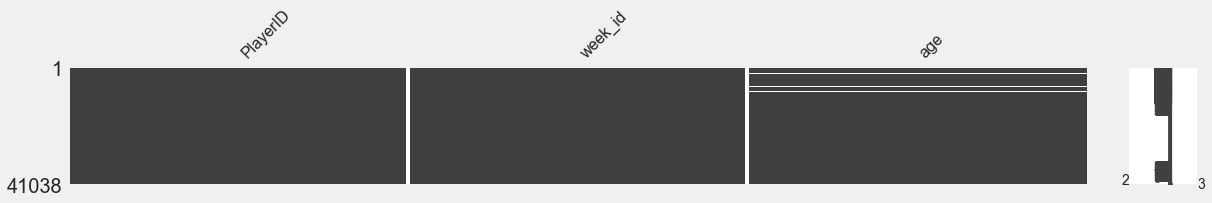

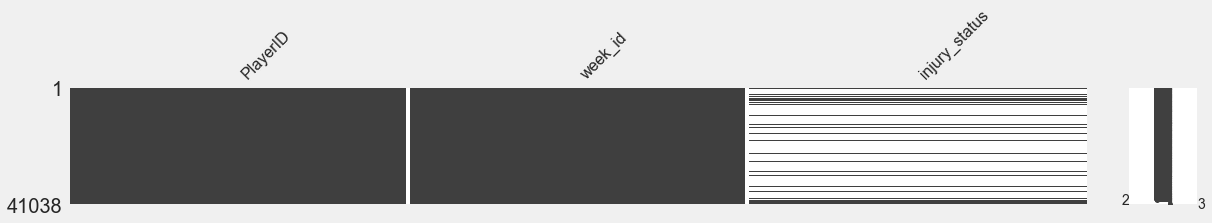

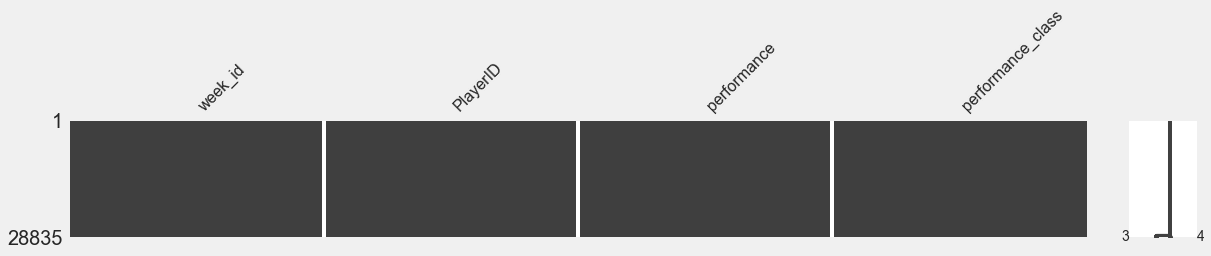

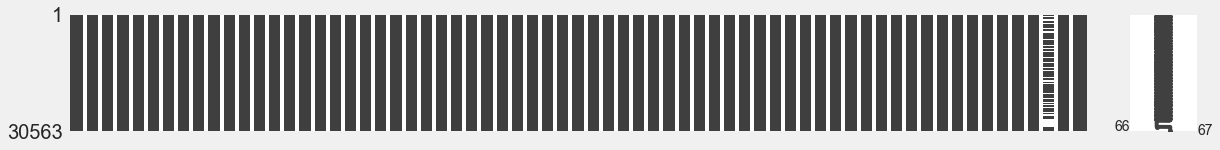

In [8]:
for n,x in zip(frames,names):
    if n.isnull().sum().sum() > 0:
        msno.matrix(n, figsize=(18, 2))
        print(x)
    else:
        pass

[return to top](#header_cell)

## Merging Datasets to Make a Dataframe
<a id='merging_datasets_cell'></a>

### 1. ```Stats``` Dataframe
<a id='stats_dataframe'></a>
First, I'll read in the ```fantasyPlayerScores.csv```, ```fantasyKickerScores.csv```, ```redzone```, and ```fantasyDefenseScores.csv``` to make a collective dataframe with all stats available. I'll also filter out all of the 2018 stats

In [9]:
# Read in dataframes, then drop select columns and filter select rows

# Player stats
df = pd.read_csv('../../fixtures/cleaned_data/fantasyPlayerScores.csv')
df = df[df['Season'] != 2018]
df = df.drop([
    'Name',
    'Number',
    'GameDate',
    'PlayerGameID',
    'FantasyPosition',
    'FantasyPointsDraftKings',
    'FantasyPointsFanDuel',
    'FantasyPoints',
    'FantasyPointsPPR',
    'SeasonType'
], axis = 'columns')

# Defense stats
defense = pd.read_csv('../../fixtures/cleaned_data/fantasyDefenseScores.csv')
defense = defense[defense['Season'] != 2018]
defense = defense.drop([
    'FantasyPointsFanDuel',
    'FantasyPointsDraftKings',
    'SeasonType',
    'Date',
    'FantasyPoints'
], axis = 'columns')

# Redzone stats
redzone = pd.read_csv('../../fixtures/cleaned_data/red_zone_stats.csv')
redzone = redzone[redzone['Season'] != 2018]
redzone = redzone.drop([
    'Name',
    'FantasyPointsRZ'
], axis = 'columns')

# Kicker stats
kickers = pd.read_csv('../../fixtures/cleaned_data/fantasyKickerScores.csv')
kickers = kickers[kickers['Season'] != 2018]
kickers = kickers.drop([
    'Unnamed: 0',
    'SeasonType',
    'GameDate',
    'Number',
    'Name',
    'FantasyPoints',
    'FantasyPointsPPR',
    'FantasyPosition',
    'FantasyPointsFanDuel',
    'FantasyPointsDraftKings'
], axis = 'columns')

#### Prepare each dataframe for merging into a bigger dataframe

In [10]:
defense['Position'] = 'DEF'
defense['PositionCategory'] = 'DEF'
defense['Started'] = 1
defense['Played'] = 1

add_these_to_defense = [item for item in list(df) if item not in list(defense)]

for n in add_these_to_defense:
    defense[n] = 0

In [11]:
add_these_to_df = list(set(list(defense)) - set(list(df)))

for n in add_these_to_df:
    df[n] = 0

In [12]:
df = pd.concat([df,defense], ignore_index = True)

In [13]:
kickers['week_id'] = kickers['Season'].astype(str) + "_" + kickers['Week'].astype(str)

add_these_to_kickers = [item for item in list(df) if item not in list(kickers)]

for n in add_these_to_kickers:
    kickers[n] = 0

In [14]:
df = pd.concat([df,kickers], ignore_index = True)

Now I have all player stats, defense stats, and kicker stats in one dataframe, I'm going to remove the individual defensive players from the shared dataframe, then bring in the redzone stats.

In [15]:
df = df[df['Position'].isin(['WR','QB','RB','TE','DEF','K'])]

In [16]:
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,FieldGoalReturnTouchdowns,DefensiveTouchdowns,SpecialTeamsTouchdowns,TouchdownsScored,BlockedKickReturnTouchdowns,Safeties,PointsAllowedByDefenseSpecialTeams,BlockedKicks,PointsAllowed,TwoPointConversionReturns,PlayerGameID
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16,15,16990,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,201910119,19781,2019,1,BAL,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3,19,16985,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,14,16991,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9,23,16993,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5,32,16989,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29866,202011708,16191,2020,17,PIT,CLE,AWAY,K,ST,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Out,28,8,17506,2020_17,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,990577384.0
29867,202011716,17118,2020,17,LAC,KC,AWAY,K,ST,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,1

In [17]:
df = pd.merge(df,
              redzone.drop([
                  'Season',
                  'Week',
                  'Team',
                  'Position'
              ], axis = 'columns'),
              how = 'left',
              left_on = ['PlayerID','week_id'],
              right_on = ['PlayerID','week_id'])
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,FieldGoalReturnTouchdowns,DefensiveTouchdowns,SpecialTeamsTouchdowns,TouchdownsScored,BlockedKickReturnTouchdowns,Safeties,PointsAllowedByDefenseSpecialTeams,BlockedKicks,PointsAllowed,TwoPointConversionReturns,PlayerGameID,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16,15,16990,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,JAX,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
1,201910119,19781,2019,1,BAL,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3,19,16985,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,MIA,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,14,16991,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,IND,0.0,0.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9,23,16993,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NYG,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5,32,16989,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,LAR,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19283,202011708,16191,2020,17,PIT,CLE,AWAY,K,ST,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,

<AxesSubplot:>

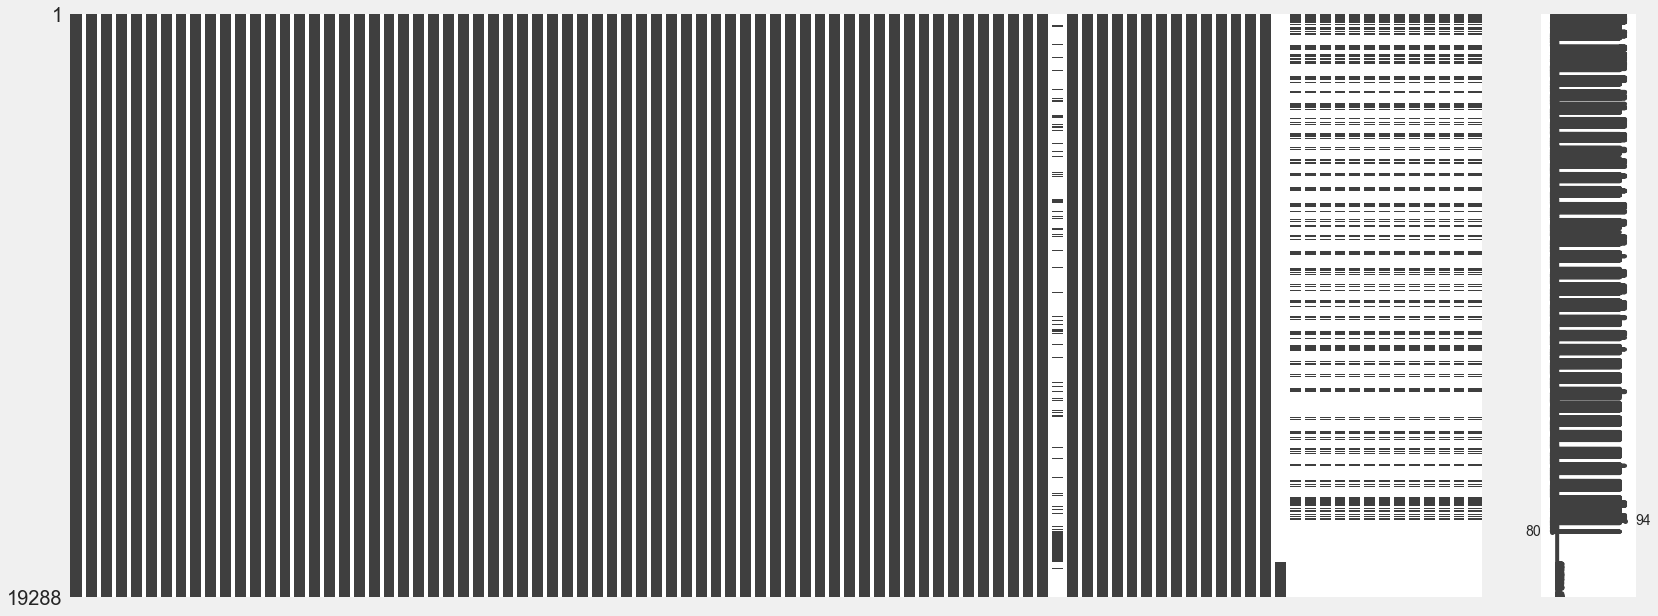

In [18]:
msno.matrix(df)

<AxesSubplot:>

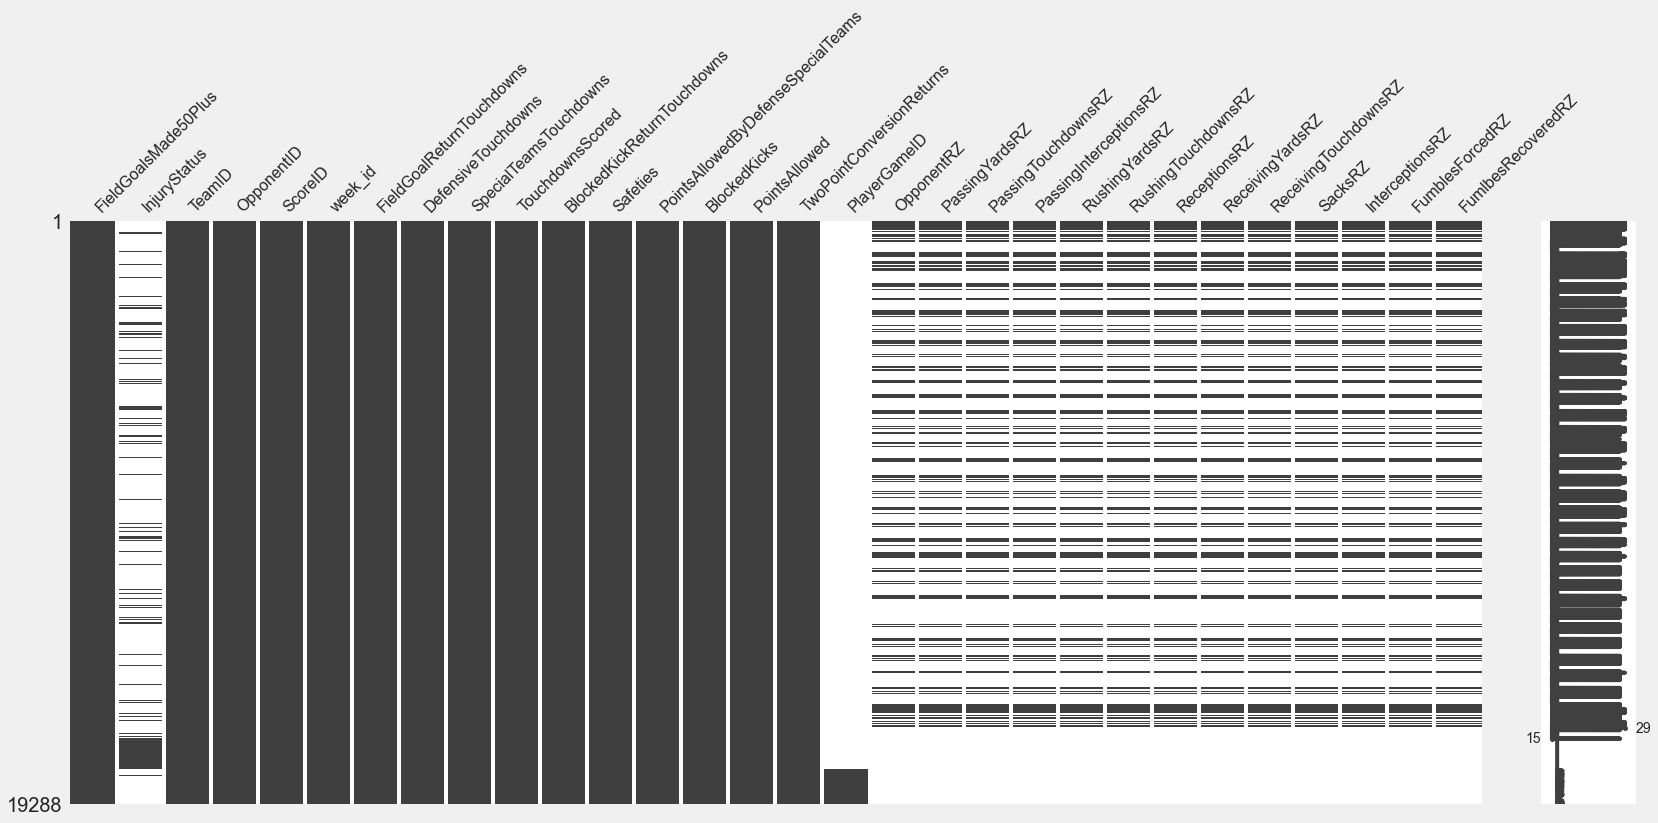

In [19]:
msno.matrix(df[list(df)[-30:]])

In [20]:
# Fill in InjuryStatus nulls
df['InjuryStatus'] = df['InjuryStatus'].apply(
    lambda x: 1 if x == "Questionable" else 0
)

# Drop PlayerGameID
df = df.drop(['PlayerGameID'], axis = 'columns')

# Fill nulls -- since there are only redzone nulls now -- with zero
df = df.fillna(0)

<AxesSubplot:>

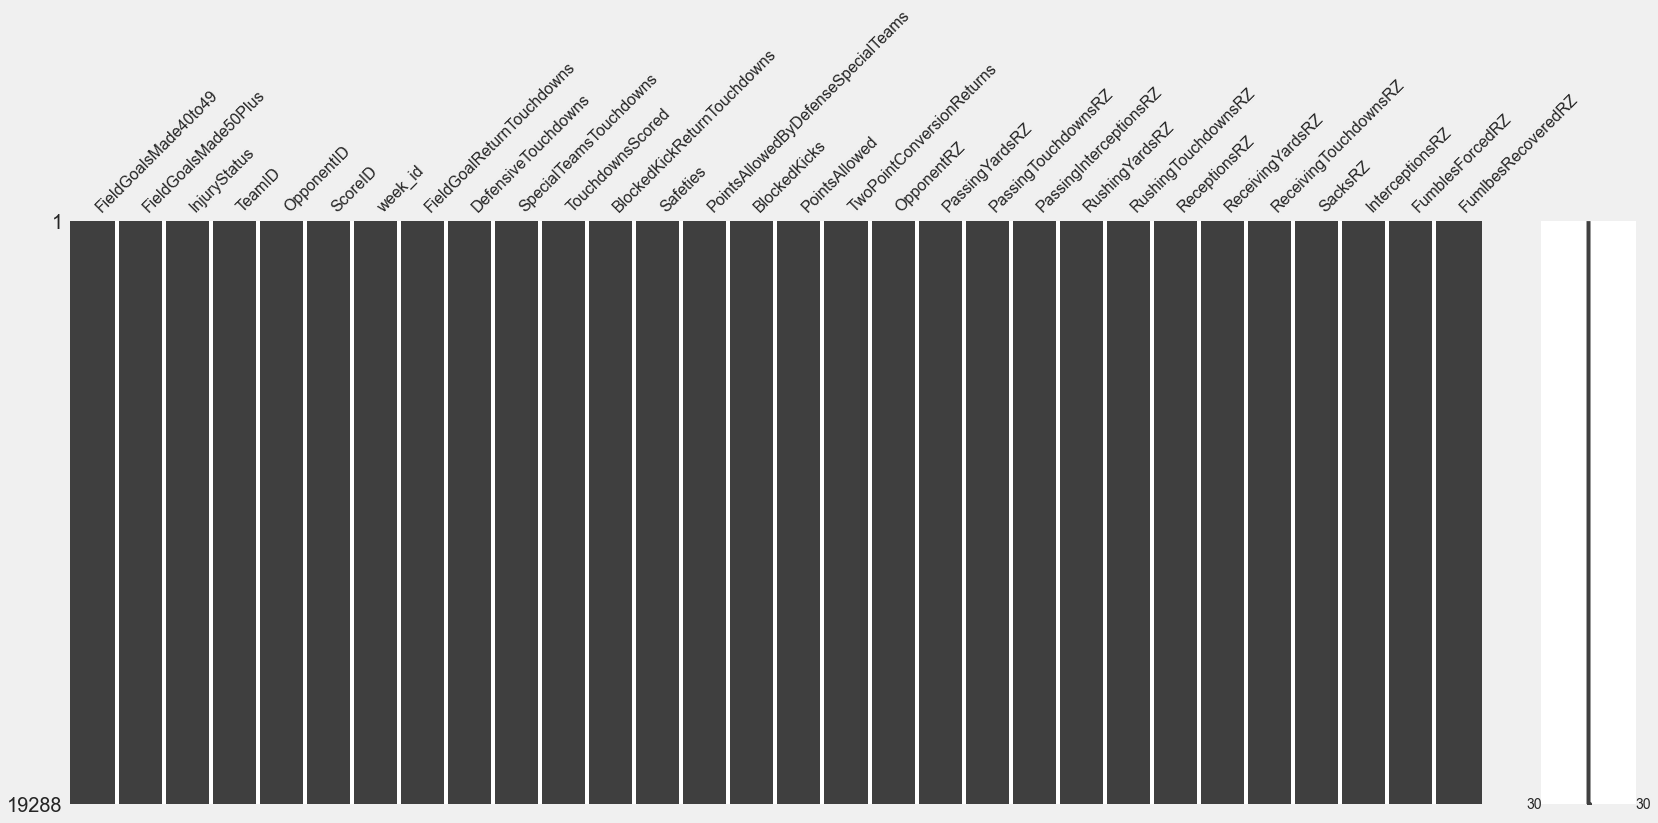

In [21]:
msno.matrix(df[list(df)[-30:]])

[return to top](#header_cell)

### 2. ```days_since_last_game``` Dataframe
<a id='days_since_last_game_dataframe'></a>
Next, I'll merge in the ```days_since_last_game```dataframe. I know there are missing values in this one, so I'll fill them right away.

<AxesSubplot:>

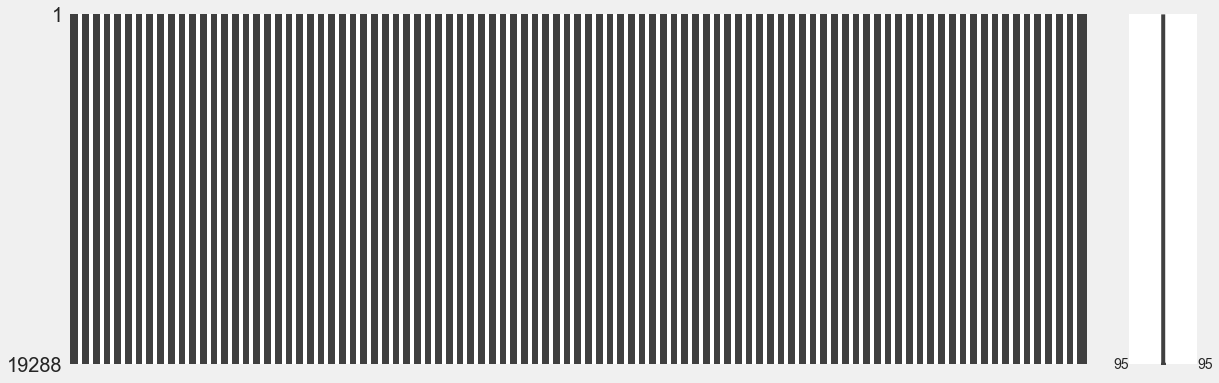

In [22]:
defense_abbrev_dict = {
    'ARI' : 'ARZ',
    'BAL' : 'BLT',
    'CLE' : 'CLV',
    'HOU' : 'HST'
}

df = df.replace({'Team': defense_abbrev_dict, 'Opponent' : defense_abbrev_dict})

df = pd.merge(df,
              days_since_last_game.replace({'Team':defense_abbrev_dict}),
              how = 'left',
              left_on = ['Team','week_id'],
              right_on = ['Team','week_id']
)

msno.matrix(df, figsize=(18,6))

[return to top](#header_cell)

### 3. ```hours_displaced``` Dataframe
<a id='hours_displaced_dataframe'></a>
I need to split the dataframe into a home and an away dataframe to facilitate merging new data that is predicated on home or away status

In [23]:
home = df[df['HomeOrAway'] == 'HOME']
away = df[df['HomeOrAway'] == 'AWAY']

In [24]:
away = pd.merge(away,
                hours_displaced[['week_id','team_away_short','absolute_hours_displaced']].rename(columns = {'team_away_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
               )

# home teams aren't displaced, and we'll treat the Mexico and England
# games as home nonetheless since there are so few
home['absolute_hours_displaced'] = 0

<ipython-input-24-82c9dc20f629>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home['absolute_hours_displaced'] = 0


HOME
AWAY


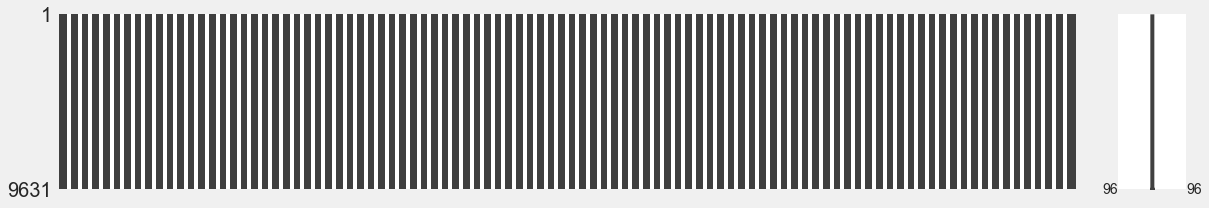

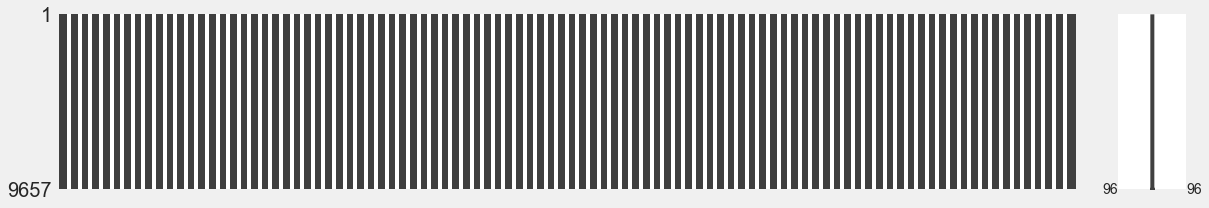

In [25]:
frames = [home, away]

for n in frames:
    print(n['HomeOrAway'].iloc[0])
    msno.matrix(n, figsize = (18, 3))

[return to top](#header_cell)

### 4. ```weather``` Dataframe
<a id='weather_dataframe'></a>
Using the split ```home``` and ```away``` dataframes, I'll add weather data

In [26]:
home = pd.merge(home,
                weather.drop('team_away_short', axis = 'columns').rename(columns = {'team_home_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
)

away = pd.merge(away,
                weather.drop('team_home_short', axis = 'columns').rename(columns = {'team_away_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
)

[return to top](#header_cell)

### 5. ```elevation``` Dataframe
<a id='elevation_dataframe'></a>
Using the split ```home``` and ```away``` dataframes, I'll add elevation data. I need to replace the team names using a dictionary first

In [27]:
name_dict = {
    'Chargers' : 'LAC',
    'Cowboys' : 'DAL',
    'Panthers' : 'CAR',
    'Eagles' : 'PHI',
    'Patriots' : 'NE',
    'Vikings' : 'MIN',
    'Raiders' : 'LV',
    'Cardinals' : 'ARZ',
    'Saints' : 'NO',
    'Jaguars' : 'JAX',
    'Seahawks' : 'SEA',
    'Jets' : 'NYJ',
    'Buccaneers' : 'TB',
    'Bears' : 'CHI',
    'Dolphins' : 'MIA',
    'Browns' : 'CLV',
    'Ravens' : 'BLT',
    'Falcons' : 'ATL',
    'Packers' : 'GB',
    'Giants' : 'NYG',
    'Rams' : 'LAR',
    'Bengals' : 'CIN',
    'Broncos' : 'DEN',
    'Lions' : 'DET',
    'Redskins' : 'WAS',
    'Steelers' : 'PIT',
    'Titans' : 'TEN',
    'Texans' : 'HST',
    'Chiefs' : 'KC',
    'Colts' : 'IND',
    'Bills' : 'BUF',
    'Forty-Niners' : 'SF'
}

elevation = elevation.replace({'Team' : name_dict})

In [28]:
# home teams aren't displaced, and we'll treat the Mexico and England
# games as home nonetheless since there are so few 
home['elevation_displacement'] = 0

In [29]:
away

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,FieldGoalReturnTouchdowns,DefensiveTouchdowns,SpecialTeamsTouchdowns,TouchdownsScored,BlockedKickReturnTouchdowns,Safeties,PointsAllowedByDefenseSpecialTeams,BlockedKicks,PointsAllowed,TwoPointConversionReturns,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,16,15,16990,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JAX,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,365,1,93,3,SouthWest,0.00,0.0,0.48,Clear
1,201910119,19781,2019,1,BLT,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,19,16985,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIA,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,0,89,7,SouthEast,0.67,0.0,0.63,Humid and Mostly Cloudy
2,201910122,18857,2019,1,HST,NO,AWAY,QB,OFF,1,1,30.0,20.0,268.0,66.7,8.9,13.4,3.0,1.0,114.31,54.0,6.0,34.0,4.0,40.0,10.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13,22,16997,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NO,36.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,0,72,0,No wind,0.55,0.0,0.60,DOME
3,201910108,17959,2019,1,TEN,CLV,AWAY,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,84.0,4.4,1.0,18.0,2.0,1.0,75.0,75.0,1.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34,8,16984,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CLE,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,1,69,6,NorthEast,0.61,0.0,0.64,Mostly Cloudy
4,201910130,18881,2019,1,CIN,SEA,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,158.0,22.6,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,30,16992,2019_1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SEA,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,365,3,66,4,South,0.96,0.0,0.76,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [30]:
elevation_displacement = []

for n in range(0,len(away)):
    elevation_displacement.append(
        (abs(
            int(
                elevation.loc[elevation['Team'] == away.iloc[n,4], 'elevation']) - int(elevation.loc[elevation['Team'] == away.iloc[n,5], 'elevation']))))

In [31]:
away['elevation_displacement'] = elevation_displacement

HOME
AWAY


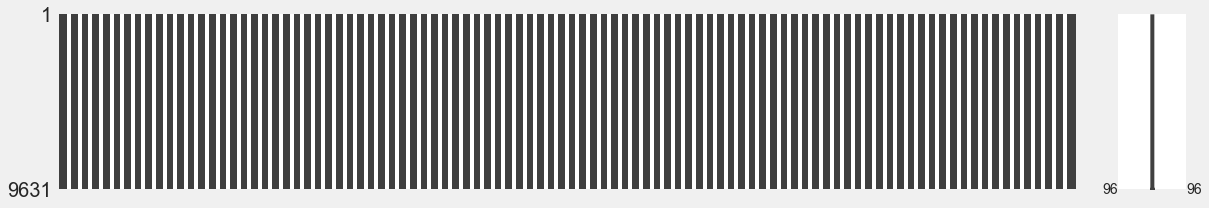

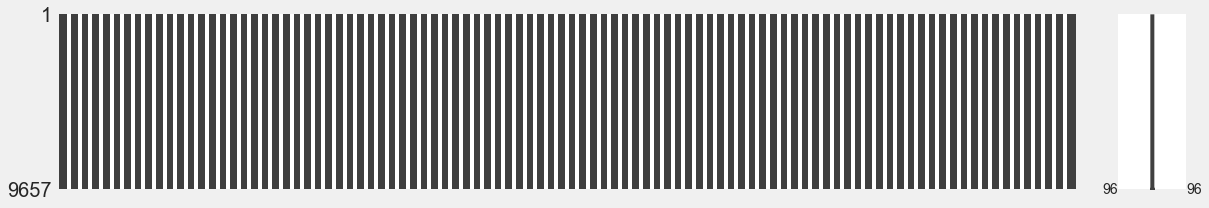

In [32]:
for n in frames:
    print(n['HomeOrAway'].iloc[0])
    msno.matrix(n, figsize = (18, 3))

[return to top](#header_cell)

### 6. Concatenating the ```home``` and ```away``` Dataframes
<a id='concat_home_away_dataframe'></a>

In [33]:
df = pd.concat([home,away], ignore_index = True)

<AxesSubplot:>

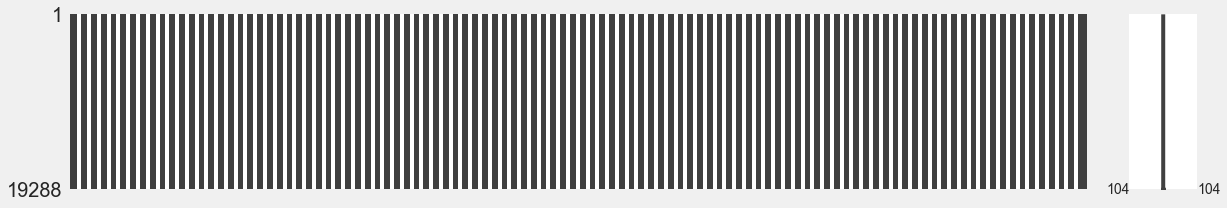

In [34]:
msno.matrix(df, figsize = (18,3))

[return to top](#header_cell)

### 7. Adding ```player_age``` to Dataframe
<a id='adding_age_dataframe'></a>

In [35]:
df = pd.merge(df,
              player_age,
              how = 'left',
              left_on = ['week_id','PlayerID'],
              right_on = ['week_id','PlayerID']
)

<AxesSubplot:>

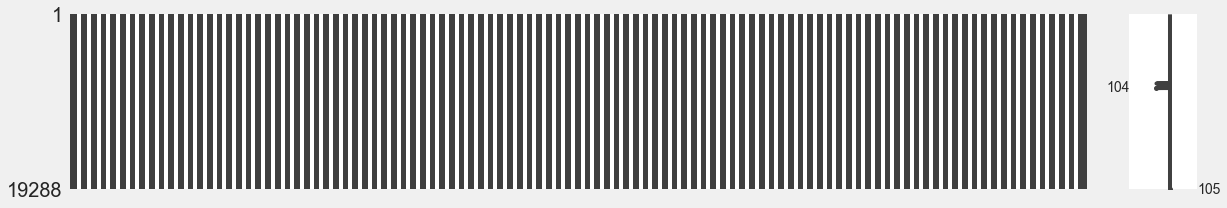

In [36]:
msno.matrix(df, figsize = (18,3))

In [37]:
df[df['age'].isna()]

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,FieldGoalReturnTouchdowns,DefensiveTouchdowns,SpecialTeamsTouchdowns,TouchdownsScored,BlockedKickReturnTouchdowns,Safeties,PointsAllowedByDefenseSpecialTeams,BlockedKicks,PointsAllowed,TwoPointConversionReturns,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age
7626,202011419,20649,2020,14,MIA,KC,HOME,WR,OFF,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,19,16,17459,2020_14,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,80,5,SouthEast,0.24,0.0,0.66,Clear,0,NaN
8126,202011622,17289,2020,16,NO,MIN,HOME,WR,OFF,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,20,17487,2020_16,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,72,0,No wind,0.00,0.0,0.28,DOME,0,NaN


In [38]:
df.at[8126,'age'] = 28.840257
df.at[7626,'age'] = df['age'].median()

<AxesSubplot:>

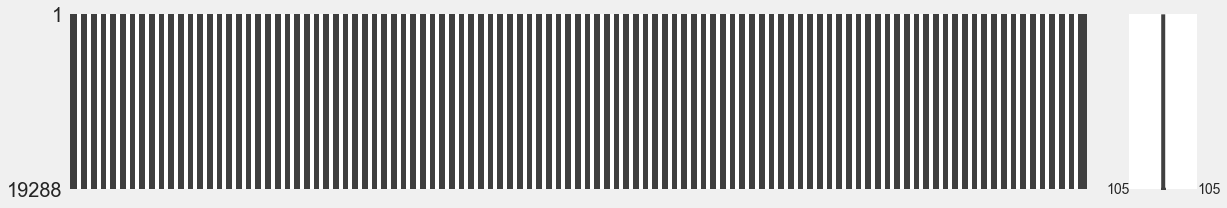

In [39]:
msno.matrix(df, figsize = (18,3))

[return to top](#header_cell)

### 8. Shifting all stats columns 1 week
<a id='shifting_stats'></a>
Select columns that are weekly stats columns

In [41]:
stat_cols = [
    'Played',
    'Started',
    'PassingAttempts',
    'PassingCompletions',
    'PassingYards',
    'PassingCompletionPercentage',
    'PassingYardsPerAttempt',
    'PassingYardsPerCompletion',
    'PassingTouchdowns',
    'PassingInterceptions',
    'PassingRating',
    'PassingLong',
    'PassingSacks',
    'PassingSackYards',
    'RushingAttempts',
    'RushingYards',
    'RushingYardsPerAttempt',
    'RushingTouchdowns',
    'RushingLong',
    'ReceivingTargets',
    'Receptions',
    'ReceivingYards',
    'ReceivingYardsPerReception',
    'ReceivingTouchdowns',
    'ReceivingLong',
    'Fumbles',
    'FumblesLost',
    'PuntReturns',
    'PuntReturnYards',
    'PuntReturnTouchdowns',
    'KickReturns',
    'KickReturnYards',
    'KickReturnTouchdowns',
    'SoloTackles',
    'AssistedTackles',
    'TacklesForLoss',
    'Sacks',
    'SackYards',
    'QuarterbackHits',
    'PassesDefended',
    'FumblesForced',
    'FumblesRecovered',
    'FumbleReturnTouchdowns',
    'Interceptions',
    'InterceptionReturnTouchdowns',
    'FieldGoalsAttempted',
    'FieldGoalsMade',
    'ExtraPointsMade',
    'TwoPointConversionPasses',
    'TwoPointConversionRuns',
    'TwoPointConversionReceptions',
    'ExtraPointsAttempted',
    'FieldGoalsMade0to19',
    'FieldGoalsMade20to29',
    'FieldGoalsMade30to39',
    'FieldGoalsMade40to49',
    'FieldGoalsMade50Plus',
    'PointsAllowedByDefenseSpecialTeams',
    'BlockedKickReturnTouchdowns',
    'PointsAllowed',
    'SpecialTeamsTouchdowns',
    'DefensiveTouchdowns',
    'BlockedKicks',
    'TwoPointConversionReturns',
    'FieldGoalReturnTouchdowns',
    'Safeties',
    'TouchdownsScored',
    'PassingYardsRZ',
    'PassingTouchdownsRZ',
    'PassingInterceptionsRZ',
    'RushingYardsRZ',
    'RushingTouchdownsRZ',
    'ReceptionsRZ',
    'ReceivingYardsRZ',
    'ReceivingTouchdownsRZ',
    'SacksRZ',
    'InterceptionsRZ',
    'FumblesForcedRZ',
    'FumlbesRecoveredRZ'
]

Peel out the non-stats columns into a separate list

In [42]:
other_cols = [item for item in list(df) if item not in list(stat_cols)]
other_cols

['GameKey',
 'PlayerID',
 'Season',
 'Week',
 'Team',
 'Opponent',
 'HomeOrAway',
 'Position',
 'PositionCategory',
 'InjuryStatus',
 'TeamID',
 'OpponentID',
 'ScoreID',
 'week_id',
 'OpponentRZ',
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_wind_direction',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'weather_detail',
 'elevation_displacement',
 'age']

Create a new list that is ordered by non-stas columns, then stats columns. Then, find out which list position is the point at which non-stats and stats deviate

In [43]:
new_cols = other_cols + stat_cols
split_point = len(new_cols) - len(stat_cols)

if new_cols[split_point] != 'Played':
    print('Error')

Reorder the dataframe according to this list

In [44]:
df = df[new_cols]
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ
0,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,0,29,14,16991,2019_1,IND,365,0,73,6,South - SouthWest,0.40,0.0,0.67,Clear,0,24.314449,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,0,9,23,16993,2019_1,NYG,365,0,72,0,No wind,0.80,0.0,0.28,DOME,0,26.113292,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,0,5,32,16989,2019_1,LAR,365,0,85,3,East,0.00,0.0,0.48,Clear,0,23.254527,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201910126,3943,2019,1,PHI,WAS,HOME,WR,OFF,0,26,35,16988,2019_1,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,154.0,19.2,2.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201910121,4314,2019,1,NE,PIT,HOME,QB,OFF,0,21,28,16996,2019_1,PIT,365,0,64,3,NorthWest,0.35,0.0,0.66,Partly Cloudy,0,42.100378,1,1,36.0,24.0,341.0,66.7,9.5,14.2,3.0,0.0,124.88,58.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,

Split the dataframe into 2019 and 2020 dataframes, then add a new ```PlayerID_x``` column on which to sort the dataframes

In [104]:
# Prep the dataframes for stat_shifter
stats_2019 = df[df['Season'] == 2019]
stats_2020 = df[df['Season'] == 2020]

stats_2019['PlayerID_x'] = stats_2019['PlayerID']
stats_2020['PlayerID_x'] = stats_2020['PlayerID']

frames = [stats_2019, stats_2020]

<ipython-input-104-0c60ea5f03dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_2019['PlayerID_x'] = stats_2019['PlayerID']
<ipython-input-104-0c60ea5f03dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_2020['PlayerID_x'] = stats_2020['PlayerID']


Set a new index, then sort by ```PlayerID``` and ```Week```

In [105]:
stats_2019 = stats_2019.set_index('PlayerID_x').sort_values(by = ['PlayerID','Week'], ascending = True)
stats_2020 = stats_2020.set_index('PlayerID_x').sort_values(by = ['PlayerID','Week'], ascending = True)

Create quality control dataframes to check against after I use ```stat_shifter```

In [106]:
quality_control_2019 = stats_2019[stats_2019['PlayerID'].isin([1,2,5])]
quality_control_2020 = stats_2020[stats_2020['PlayerID'].isin([1,2,5])]

Create a testing dataframe to run ```stat_shifter``` on prior to running the whole dataframe through it

In [ ]:
tester_2019 = quality_control_2019.copy()

In [ ]:
quality_control_2019[['PlayerID','week_id','Safeties']]

In [ ]:
tester_2019[['PlayerID','week_id','Safeties']]

Here's the right one

In [66]:
stats_2019

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ
PlayerID_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,201910101,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,0,365,0,72,0,No wind,0.39,0.00,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201910203,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,0,7,2,81,3,North - NorthWest,0.00,0.00,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201910301,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,0,7,0,72,0,No wind,0.40,0.00,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201910401,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,0,7,0,72,0,No wind,0.38,0.00,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,38.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201910507,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,0,7,2,76,6,West - SouthWest,0.87,0.00,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
unique_players_2019 = list(stats_2019['PlayerID'].unique())

for n in unique_players_2019:
    for row in range(len(stats_2019[stats_2019['PlayerID'] == n])-1,-1,-1):
        for x in range(split_point,stats_2019.shape[1]):
            if len(stats_2019[stats_2019['PlayerID'] == n]) >= row > 0:
                try:
                    stats_2019.loc[n,new_cols[x]].iloc[row] = stats_2019.loc[n,new_cols[x]].iloc[row-1]
                except Exception:
                    print(f'Error found with Player {n} at row {row} and column {x}')
                    pass
            else:
                try:
                    stats_2019.loc[n,new_cols[x]].iloc[row] = 0
                except Exception:
                    print(f'Error found with Player {n} at row {row} and column {x}')
                    pass

Error found with Player 10333 at row 0 and column 26
Error found with Player 10333 at row 0 and column 27
Error found with Player 10333 at row 0 and column 28
Error found with Player 10333 at row 0 and column 29
Error found with Player 10333 at row 0 and column 30
Error found with Player 10333 at row 0 and column 31
Error found with Player 10333 at row 0 and column 32
Error found with Player 10333 at row 0 and column 33
Error found with Player 10333 at row 0 and column 34
Error found with Player 10333 at row 0 and column 35
Error found with Player 10333 at row 0 and column 36
Error found with Player 10333 at row 0 and column 37
Error found with Player 10333 at row 0 and column 38
Error found with Player 10333 at row 0 and column 39
Error found with Player 10333 at row 0 and column 40
Error found with Player 10333 at row 0 and column 41
Error found with Player 10333 at row 0 and column 42
Error found with Player 10333 at row 0 and column 43
Error found with Player 10333 at row 0 and col

Error found with Player 14533 at row 0 and column 26
Error found with Player 14533 at row 0 and column 27
Error found with Player 14533 at row 0 and column 28
Error found with Player 14533 at row 0 and column 29
Error found with Player 14533 at row 0 and column 30
Error found with Player 14533 at row 0 and column 31
Error found with Player 14533 at row 0 and column 32
Error found with Player 14533 at row 0 and column 33
Error found with Player 14533 at row 0 and column 34
Error found with Player 14533 at row 0 and column 35
Error found with Player 14533 at row 0 and column 36
Error found with Player 14533 at row 0 and column 37
Error found with Player 14533 at row 0 and column 38
Error found with Player 14533 at row 0 and column 39
Error found with Player 14533 at row 0 and column 40
Error found with Player 14533 at row 0 and column 41
Error found with Player 14533 at row 0 and column 42
Error found with Player 14533 at row 0 and column 43
Error found with Player 14533 at row 0 and col

Error found with Player 16063 at row 0 and column 26
Error found with Player 16063 at row 0 and column 27
Error found with Player 16063 at row 0 and column 28
Error found with Player 16063 at row 0 and column 29
Error found with Player 16063 at row 0 and column 30
Error found with Player 16063 at row 0 and column 31
Error found with Player 16063 at row 0 and column 32
Error found with Player 16063 at row 0 and column 33
Error found with Player 16063 at row 0 and column 34
Error found with Player 16063 at row 0 and column 35
Error found with Player 16063 at row 0 and column 36
Error found with Player 16063 at row 0 and column 37
Error found with Player 16063 at row 0 and column 38
Error found with Player 16063 at row 0 and column 39
Error found with Player 16063 at row 0 and column 40
Error found with Player 16063 at row 0 and column 41
Error found with Player 16063 at row 0 and column 42
Error found with Player 16063 at row 0 and column 43
Error found with Player 16063 at row 0 and col

Error found with Player 17121 at row 0 and column 26
Error found with Player 17121 at row 0 and column 27
Error found with Player 17121 at row 0 and column 28
Error found with Player 17121 at row 0 and column 29
Error found with Player 17121 at row 0 and column 30
Error found with Player 17121 at row 0 and column 31
Error found with Player 17121 at row 0 and column 32
Error found with Player 17121 at row 0 and column 33
Error found with Player 17121 at row 0 and column 34
Error found with Player 17121 at row 0 and column 35
Error found with Player 17121 at row 0 and column 36
Error found with Player 17121 at row 0 and column 37
Error found with Player 17121 at row 0 and column 38
Error found with Player 17121 at row 0 and column 39
Error found with Player 17121 at row 0 and column 40
Error found with Player 17121 at row 0 and column 41
Error found with Player 17121 at row 0 and column 42
Error found with Player 17121 at row 0 and column 43
Error found with Player 17121 at row 0 and col

Error found with Player 17939 at row 0 and column 26
Error found with Player 17939 at row 0 and column 27
Error found with Player 17939 at row 0 and column 28
Error found with Player 17939 at row 0 and column 29
Error found with Player 17939 at row 0 and column 30
Error found with Player 17939 at row 0 and column 31
Error found with Player 17939 at row 0 and column 32
Error found with Player 17939 at row 0 and column 33
Error found with Player 17939 at row 0 and column 34
Error found with Player 17939 at row 0 and column 35
Error found with Player 17939 at row 0 and column 36
Error found with Player 17939 at row 0 and column 37
Error found with Player 17939 at row 0 and column 38
Error found with Player 17939 at row 0 and column 39
Error found with Player 17939 at row 0 and column 40
Error found with Player 17939 at row 0 and column 41
Error found with Player 17939 at row 0 and column 42
Error found with Player 17939 at row 0 and column 43
Error found with Player 17939 at row 0 and col

Error found with Player 18253 at row 0 and column 26
Error found with Player 18253 at row 0 and column 27
Error found with Player 18253 at row 0 and column 28
Error found with Player 18253 at row 0 and column 29
Error found with Player 18253 at row 0 and column 30
Error found with Player 18253 at row 0 and column 31
Error found with Player 18253 at row 0 and column 32
Error found with Player 18253 at row 0 and column 33
Error found with Player 18253 at row 0 and column 34
Error found with Player 18253 at row 0 and column 35
Error found with Player 18253 at row 0 and column 36
Error found with Player 18253 at row 0 and column 37
Error found with Player 18253 at row 0 and column 38
Error found with Player 18253 at row 0 and column 39
Error found with Player 18253 at row 0 and column 40
Error found with Player 18253 at row 0 and column 41
Error found with Player 18253 at row 0 and column 42
Error found with Player 18253 at row 0 and column 43
Error found with Player 18253 at row 0 and col

Error found with Player 18673 at row 0 and column 26
Error found with Player 18673 at row 0 and column 27
Error found with Player 18673 at row 0 and column 28
Error found with Player 18673 at row 0 and column 29
Error found with Player 18673 at row 0 and column 30
Error found with Player 18673 at row 0 and column 31
Error found with Player 18673 at row 0 and column 32
Error found with Player 18673 at row 0 and column 33
Error found with Player 18673 at row 0 and column 34
Error found with Player 18673 at row 0 and column 35
Error found with Player 18673 at row 0 and column 36
Error found with Player 18673 at row 0 and column 37
Error found with Player 18673 at row 0 and column 38
Error found with Player 18673 at row 0 and column 39
Error found with Player 18673 at row 0 and column 40
Error found with Player 18673 at row 0 and column 41
Error found with Player 18673 at row 0 and column 42
Error found with Player 18673 at row 0 and column 43
Error found with Player 18673 at row 0 and col

Error found with Player 19206 at row 0 and column 26
Error found with Player 19206 at row 0 and column 27
Error found with Player 19206 at row 0 and column 28
Error found with Player 19206 at row 0 and column 29
Error found with Player 19206 at row 0 and column 30
Error found with Player 19206 at row 0 and column 31
Error found with Player 19206 at row 0 and column 32
Error found with Player 19206 at row 0 and column 33
Error found with Player 19206 at row 0 and column 34
Error found with Player 19206 at row 0 and column 35
Error found with Player 19206 at row 0 and column 36
Error found with Player 19206 at row 0 and column 37
Error found with Player 19206 at row 0 and column 38
Error found with Player 19206 at row 0 and column 39
Error found with Player 19206 at row 0 and column 40
Error found with Player 19206 at row 0 and column 41
Error found with Player 19206 at row 0 and column 42
Error found with Player 19206 at row 0 and column 43
Error found with Player 19206 at row 0 and col

Error found with Player 20264 at row 0 and column 26
Error found with Player 20264 at row 0 and column 27
Error found with Player 20264 at row 0 and column 28
Error found with Player 20264 at row 0 and column 29
Error found with Player 20264 at row 0 and column 30
Error found with Player 20264 at row 0 and column 31
Error found with Player 20264 at row 0 and column 32
Error found with Player 20264 at row 0 and column 33
Error found with Player 20264 at row 0 and column 34
Error found with Player 20264 at row 0 and column 35
Error found with Player 20264 at row 0 and column 36
Error found with Player 20264 at row 0 and column 37
Error found with Player 20264 at row 0 and column 38
Error found with Player 20264 at row 0 and column 39
Error found with Player 20264 at row 0 and column 40
Error found with Player 20264 at row 0 and column 41
Error found with Player 20264 at row 0 and column 42
Error found with Player 20264 at row 0 and column 43
Error found with Player 20264 at row 0 and col

Error found with Player 20373 at row 0 and column 26
Error found with Player 20373 at row 0 and column 27
Error found with Player 20373 at row 0 and column 28
Error found with Player 20373 at row 0 and column 29
Error found with Player 20373 at row 0 and column 30
Error found with Player 20373 at row 0 and column 31
Error found with Player 20373 at row 0 and column 32
Error found with Player 20373 at row 0 and column 33
Error found with Player 20373 at row 0 and column 34
Error found with Player 20373 at row 0 and column 35
Error found with Player 20373 at row 0 and column 36
Error found with Player 20373 at row 0 and column 37
Error found with Player 20373 at row 0 and column 38
Error found with Player 20373 at row 0 and column 39
Error found with Player 20373 at row 0 and column 40
Error found with Player 20373 at row 0 and column 41
Error found with Player 20373 at row 0 and column 42
Error found with Player 20373 at row 0 and column 43
Error found with Player 20373 at row 0 and col

Error found with Player 21161 at row 0 and column 26
Error found with Player 21161 at row 0 and column 27
Error found with Player 21161 at row 0 and column 28
Error found with Player 21161 at row 0 and column 29
Error found with Player 21161 at row 0 and column 30
Error found with Player 21161 at row 0 and column 31
Error found with Player 21161 at row 0 and column 32
Error found with Player 21161 at row 0 and column 33
Error found with Player 21161 at row 0 and column 34
Error found with Player 21161 at row 0 and column 35
Error found with Player 21161 at row 0 and column 36
Error found with Player 21161 at row 0 and column 37
Error found with Player 21161 at row 0 and column 38
Error found with Player 21161 at row 0 and column 39
Error found with Player 21161 at row 0 and column 40
Error found with Player 21161 at row 0 and column 41
Error found with Player 21161 at row 0 and column 42
Error found with Player 21161 at row 0 and column 43
Error found with Player 21161 at row 0 and col

Error found with Player 21316 at row 0 and column 26
Error found with Player 21316 at row 0 and column 27
Error found with Player 21316 at row 0 and column 28
Error found with Player 21316 at row 0 and column 29
Error found with Player 21316 at row 0 and column 30
Error found with Player 21316 at row 0 and column 31
Error found with Player 21316 at row 0 and column 32
Error found with Player 21316 at row 0 and column 33
Error found with Player 21316 at row 0 and column 34
Error found with Player 21316 at row 0 and column 35
Error found with Player 21316 at row 0 and column 36
Error found with Player 21316 at row 0 and column 37
Error found with Player 21316 at row 0 and column 38
Error found with Player 21316 at row 0 and column 39
Error found with Player 21316 at row 0 and column 40
Error found with Player 21316 at row 0 and column 41
Error found with Player 21316 at row 0 and column 42
Error found with Player 21316 at row 0 and column 43
Error found with Player 21316 at row 0 and col

In [112]:
error_player_ids = [
    10333,
    12386,
    14533,
    15293,
    16063,
    16802,
    17121,
    17741,
    17939,
    18133,
    18253,
    18262,
    18673,
    19065,
    19206,
    19732,
    20264,
    20296,
    20373,
    20550,
    21161,
    21256,
    21263,
    21316,
    21514
]

Because all of these errors occurred at row 0, this makes me think that these errors are due to players who played only one game. Let's confirm this.

In [126]:
error_player_ids_checker = []
for n in error_player_ids:
    error_player_ids_checker.append(stats_2019[['week_id']][stats_2019['PlayerID'] == n].iloc[0])
    
if len(error_player_ids_checker) == len(error_player_ids):
    print('Confirmed, these are all single occurrence players.')
else:
    print('This is going to be a much longer night for you, try again')

Confirmed, these are all single occurrence players.


In [130]:
filtered_unique_ids = list(set(list(stats_2019['PlayerID'].unique())) - set(error_player_ids))

if len(stats_2019['PlayerID'].unique()) - len(filtered_unique_ids) == len(error_player_ids):
    stats_2019 = stats_2019[stats_2019['PlayerID'].isin(filtered_unique_ids)]
else:
    print('Error')

In [133]:
unique_players_2020 = list(stats_2020['PlayerID'].unique())
error_player_ids_2020 = []

for n in unique_players_2020:
    for row in range(len(stats_2020[stats_2020['PlayerID'] == n])-1,-1,-1):
        for x in range(split_point,stats_2020.shape[1]):
            if len(stats_2020[stats_2020['PlayerID'] == n]) >= row > 0:
                try:
                    stats_2020.loc[n,new_cols[x]].iloc[row] = stats_2020.loc[n,new_cols[x]].iloc[row-1]
                except Exception:
                    error_player_ids_2020.append(n)
                    pass
            else:
                try:
                    stats_2020.loc[n,new_cols[x]].iloc[row] = 0
                except Exception:
                    error_player_ids_2020.append(n)
                    pass

error_player_ids_2020 = list(set(error_player_ids_2020))
error_player_ids_checker_2020 = []

for n in error_player_ids_2020:
    error_player_ids_checker_2020.append(stats_2020[['week_id']][stats_2020['PlayerID'] == n].iloc[0])

    
if len(error_player_ids_checker_2020) == len(error_player_ids_2020):
    print('Confirmed, these are all single occurrence players.')
else:
    print('This is going to be a much longer night for you, try again')

    
filtered_unique_ids_2020 = list(set(list(stats_2020['PlayerID'].unique())) - set(error_player_ids_2020))


if len(stats_2020['PlayerID'].unique()) - len(filtered_unique_ids_2020) == len(error_player_ids_2020):
    stats_2020 = stats_2020[stats_2020['PlayerID'].isin(filtered_unique_ids_2020)]
else:
    print('Error')

Confirmed, these are all single occurrence players.


<AxesSubplot:>

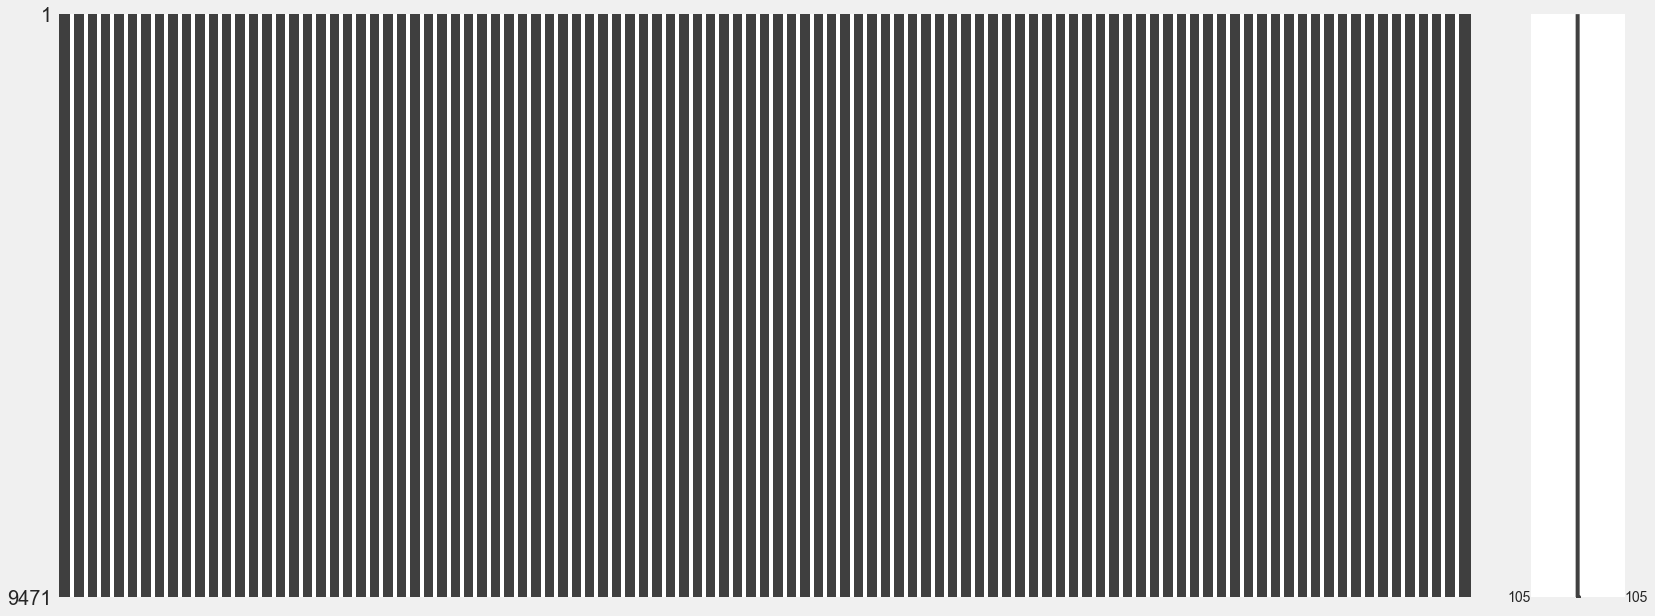

In [134]:
msno.matrix(stats_2019)

<AxesSubplot:>

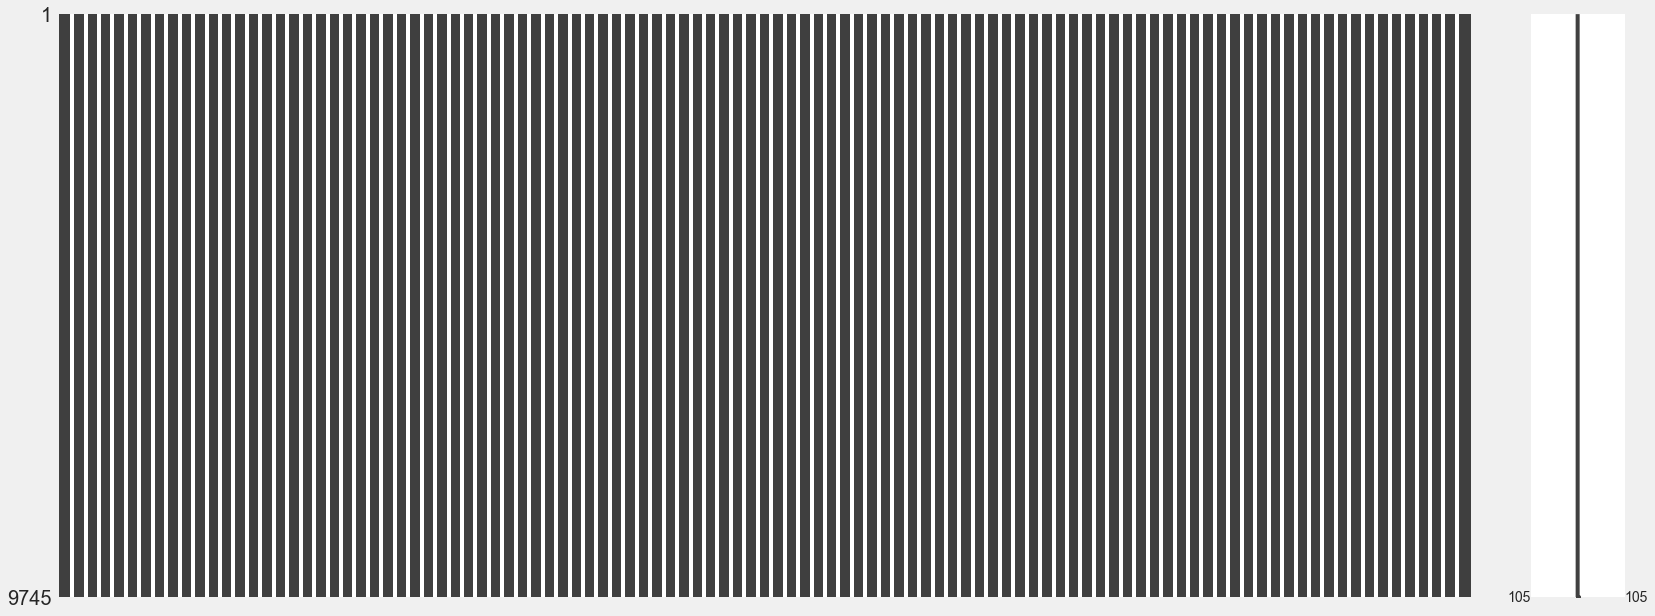

In [135]:
msno.matrix(stats_2020)

<AxesSubplot:>

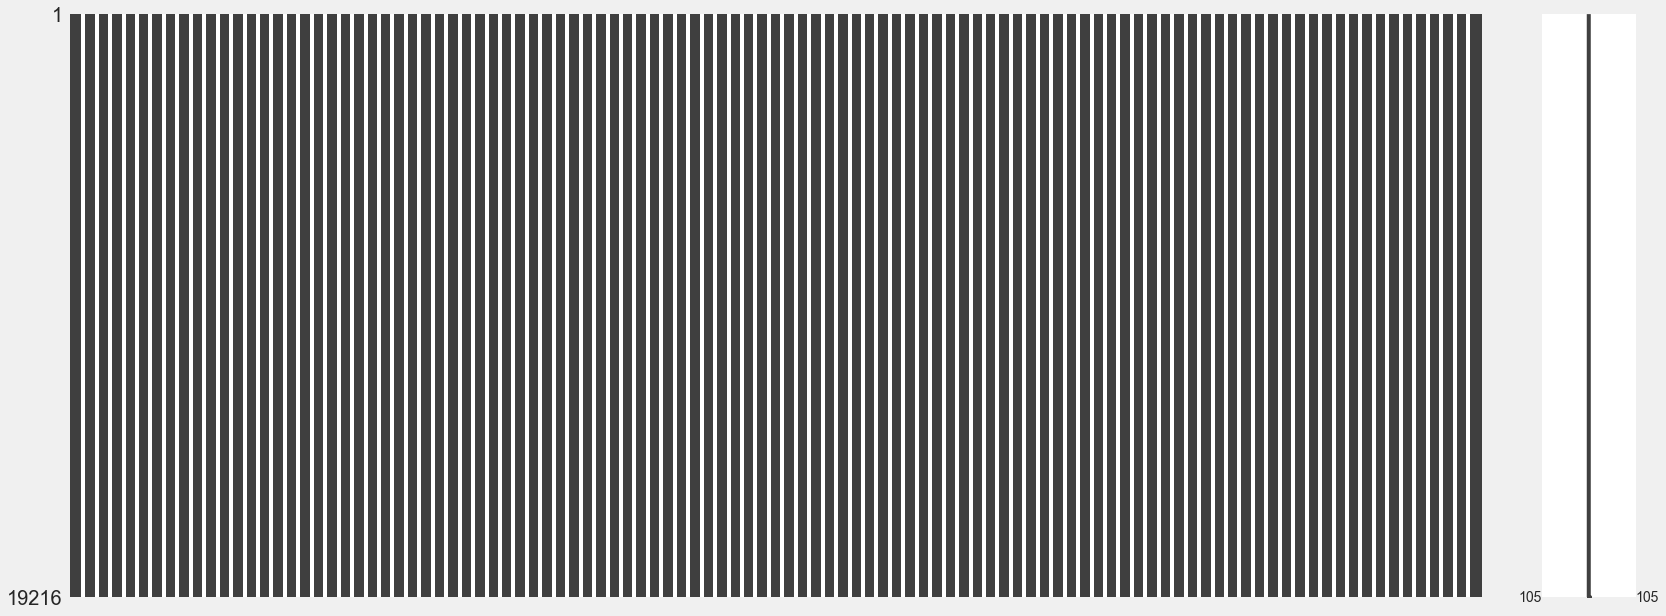

In [136]:
df = pd.concat([stats_2019,stats_2020], axis = 'rows')
msno.matrix(df)

[return to top](#header_cell)

### 9. Adding the ```target``` dataframe
<a id='target_dataframe'></a>

In [201]:
df = pd.merge(df,
              target,
              how = 'left',
              left_on = ['week_id','PlayerID'],
              right_on = ['week_id','PlayerID']
)

In [148]:
df = df.dropna().drop('GameKey', axis = 'columns')

<AxesSubplot:>

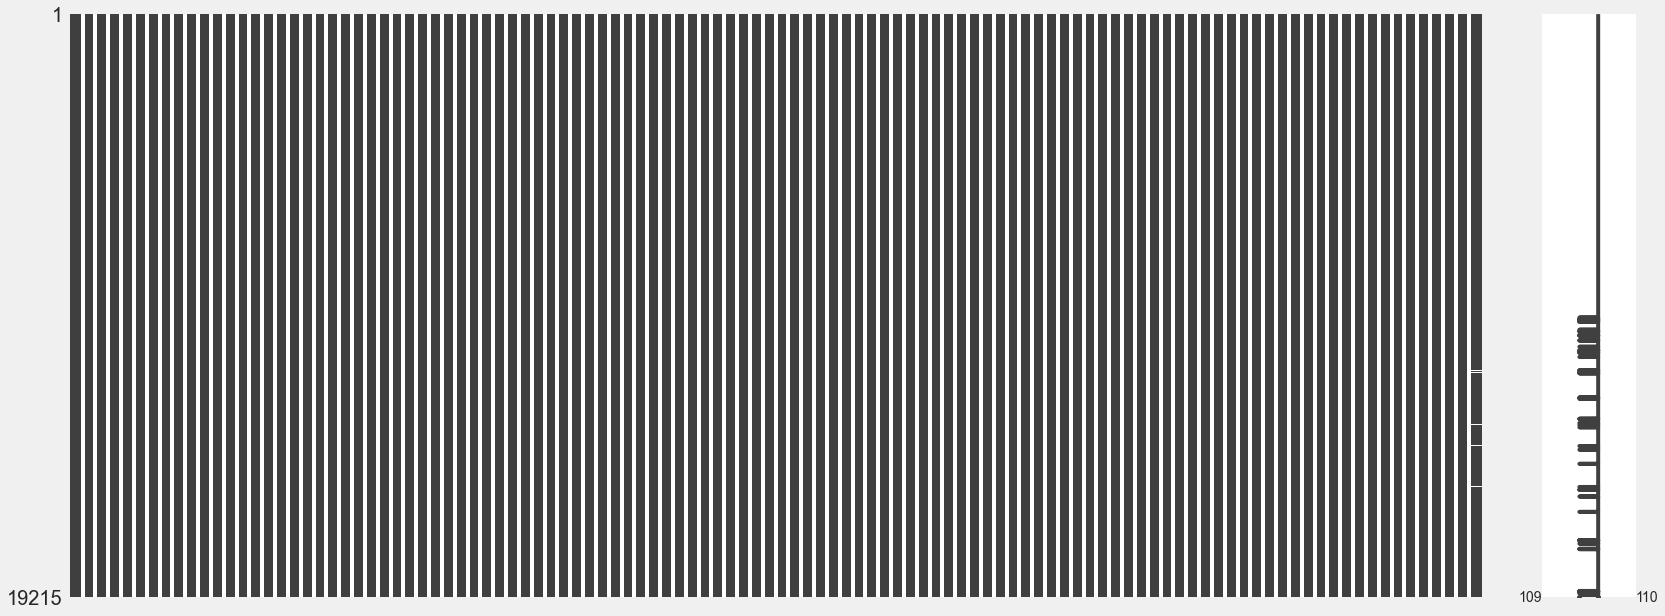

In [202]:
msno.matrix(df)

[return to top](#header_cell)

### 10. Writing the merged data for common use
<a id='writing_data'></a>
<a id='target_dataframe'></a>

In [142]:
df.to_csv('../../fixtures/cleaned_data/merged_df.csv', index = False)